In [ ]:
"""
Created on Wed Aug 4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from main import *
debug_mode = True  # faster experiments for debugging

# util for getting objects' fields' names
field_names = lambda x: list(vars(x).keys())

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")

In [3]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [5]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-05-14 15:11:34.595958: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 15:11:35.007857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14631 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [6]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'NoDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler=ipscaler="MinMaxScaler"# 'PositiveLogNormal'
#opscaler=None
ZmixPresent = 'N'
concatenateZmix = 'N'
kernel_constraint = 'N'
kernel_regularizer = 'N'
activity_regularizer = 'N'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='mae'
exprExec.modelFactory.activation_func='relu'
exprExec.modelFactory.dropout_rate=0.5
exprExec.debug_mode = False
exprExec.use_dependants = True
exprExec.use_dynamic_pred = True
exprExec.epochs_override = 100
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

history = exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                           noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                           kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                           opscaler=opscaler, ipscaler=ipscaler)

--------------------self.build_and_compile_pcdnn_v2_model----------------------
len testing df:  8222
53 4 N N N N
Model: "container_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 source_term_input (InputLayer)  [(None, 53)]        0           []                               
                                                                                                  
 emb_and_regression_model (Func  {'static_source_pre  350137     ['species_input[0][0]']          
 tional)                        diction': (None, 1)                                               
                                , 'dynamic_source_p                 

|| dense_8 (Dense)            (None, 32)           2080        []                               ||
||                                                                                              ||
|| dropout_8 (Dropout)        (None, 32)           0           []                               ||
||                                                                                              ||
|| dynamic_source_prediction (Den  (None, 4)       132         []                               ||
|| se)                                                                                          ||
||                                                                                              ||
|| static_source_prediction (Dens  (None, 1)       33          []                               ||
|| e)                                                                                           ||
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
¯¯¯¯¯¯¯¯¯¯

/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


training model: 1
Epoch 1/100
65/65 [==============================] - 3s 20ms/step - loss: 2.1185 - dynamic_source_prediction_loss: 1.7198 - emb_and_regression_model_loss: 0.3987 - dynamic_source_prediction_R2_split: -10.9156 - dynamic_source_prediction_source_pred_mean: 0.0603 - dynamic_source_prediction_source_true_mean: 1.7714 - emb_and_regression_model_mae: 0.3987 - emb_and_regression_model_mse: 0.3122 - emb_and_regression_model_R2: -22.9592 - val_loss: 1.7892 - val_dynamic_source_prediction_loss: 1.7113 - val_emb_and_regression_model_loss: 0.0780 - val_dynamic_source_prediction_R2_split: -364794121027584.0000 - val_dynamic_source_prediction_source_pred_mean: 0.0503 - val_dynamic_source_prediction_source_true_mean: 1.7616 - val_emb_and_regression_model_mae: 0.0780 - val_emb_and_regression_model_mse: 0.0270 - val_emb_and_regression_model_R2: -0.3413
Epoch 2/100
65/65 [==============================] - 1s 15ms/step - loss: 1.7780 - dynamic_source_prediction_loss: 1.4975 - emb_and_re

Epoch 11/100
61/65 [===========================>..] - ETA: 0s - loss: 0.7605 - dynamic_source_prediction_loss: 0.6049 - emb_and_regression_model_loss: 0.1557 - dynamic_source_prediction_R2_split: -0.6623 - dynamic_source_prediction_source_pred_mean: 0.8523 - dynamic_source_prediction_source_true_mean: 1.2638 - emb_and_regression_model_mae: 0.1557 - emb_and_regression_model_mse: 0.0486 - emb_and_regression_model_R2: -1.9133

KeyboardInterrupt: 

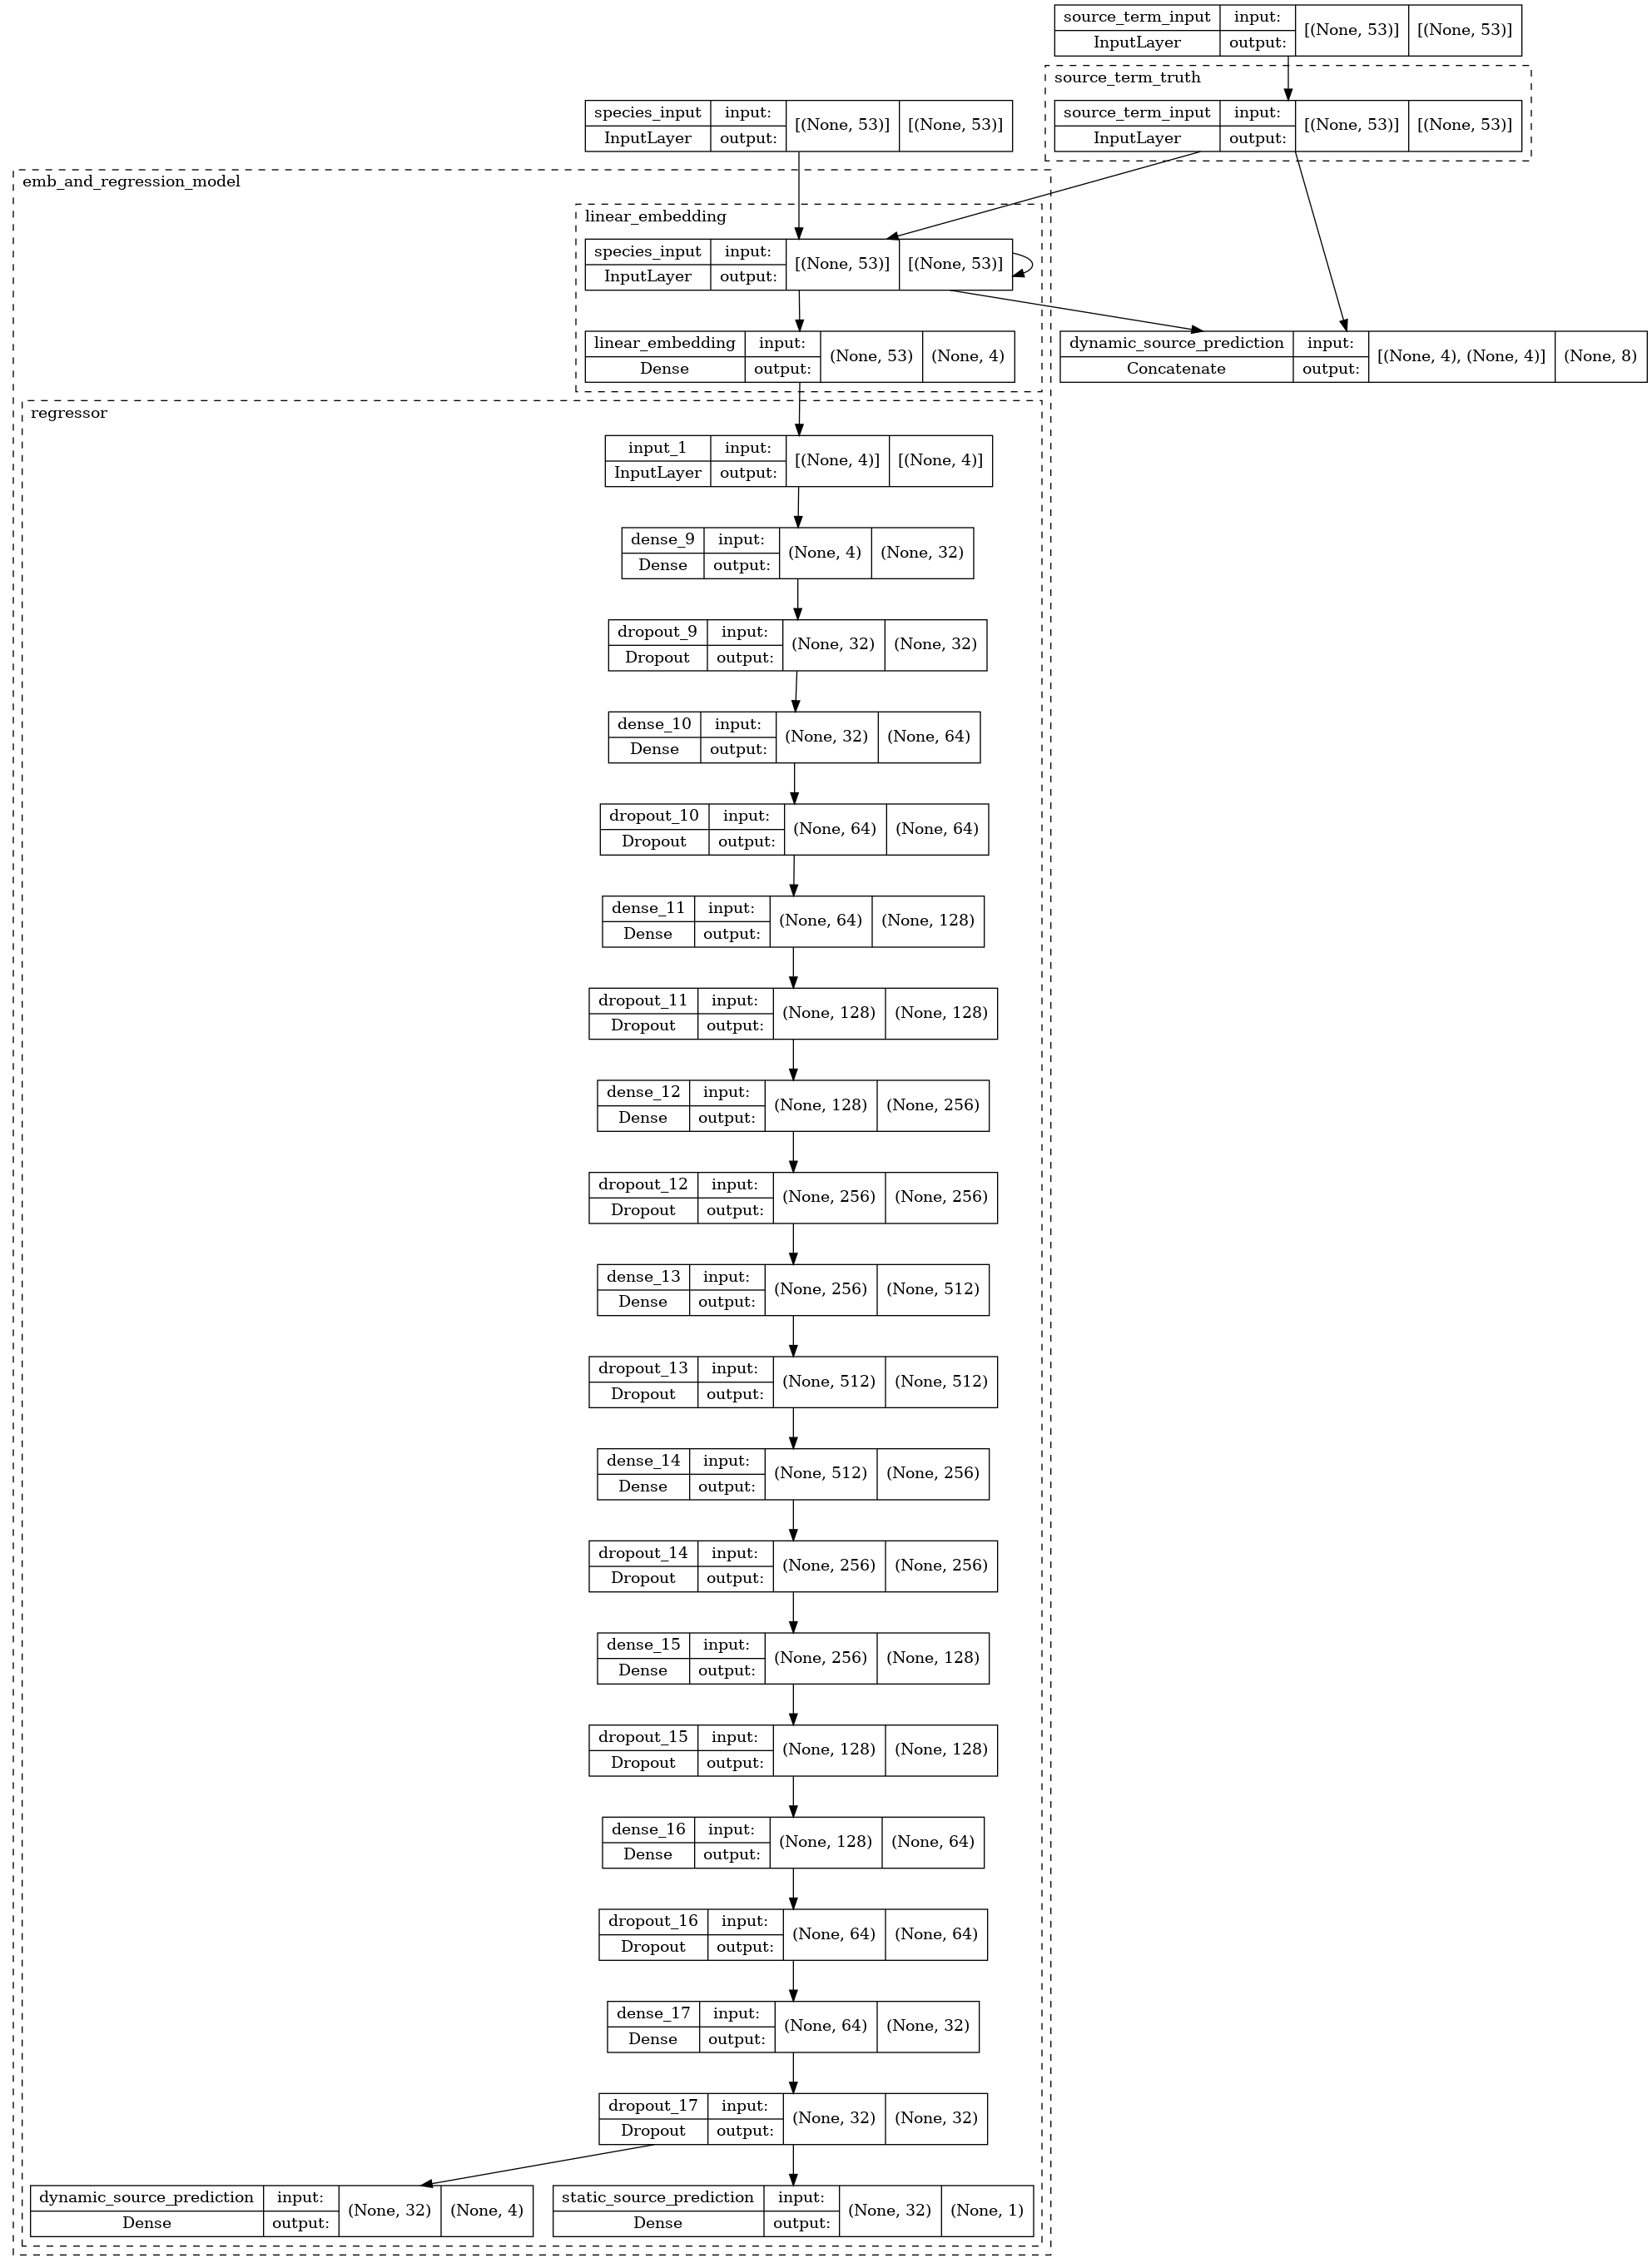

In [7]:
exprExec.modelFactory.model.save('souener_only_model_template.h5', include_optimizer=True)
tf.keras.utils.plot_model(exprExec.modelFactory.model, expand_nested=True, show_shapes=True)

## Results Plotting & Analysis

In [8]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])

print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)

len testing df:  8222

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'RobustScaler', 'noOfCpv': 10, 'ZmixPresent': 'N', 'concatenateZmix': 'N', 'kernel_constraint': 'N', 'kernel_regularizer': 'N', 'activity_regularizer': 'N', 'input_data_cols': ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiHNO', 'YiCN', 'YiHCN', 'YiH2CN', 'YiHCNN', 'YiHCNO', 'YiHOCN', 'YiHNCO', 'YiNCO', 'YiC3H7', 'YiC3H8', 'YiCH2CHO', 'YiCH3CHO', 'YiN2', 'YiAR'], 'data_manager': <data.train_test_manager.DataManager object at 0x7fbff009ef10>, 'val_losses': {'loss': -1.985823392868042, 'dynamic_source_prediction_loss': -0.9942372441291809, 'emb_an

input names: ['input_1']
output names (before pruning): ['dynamic_source_prediction', 'static_source_prediction']
['cpv1', 'cpv2', 'cpv3', 'cpv4', 'cpv5', 'cpv6', 'cpv7', 'cpv8', 'cpv9', 'cpv10']


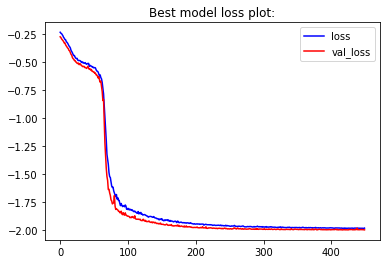

Best Model dev R^2 (combined):  0.9960790407481541
Best Model val static R^2: 0.9916111826896667
Best Model val dynamic R^2: 0.9942547678947449


In [10]:
import matplotlib.pyplot as plt
plt.plot(experimentSettings['history']['loss'][50:], color='blue')
plt.plot(experimentSettings['history']['val_loss'][50:], color='red')
plt.legend(labels=['loss', 'val_loss'])
plt.title('Best model loss plot:')
plt.show()
print('Best Model dev R^2 (combined): ', experimentSettings['model_R2'])
print('Best Model val static R^2:', experimentSettings['val_losses']['emb_and_regression_model_R2'])
print('Best Model val dynamic R^2:', experimentSettings['val_losses']['dynamic_source_prediction_R2_split'])

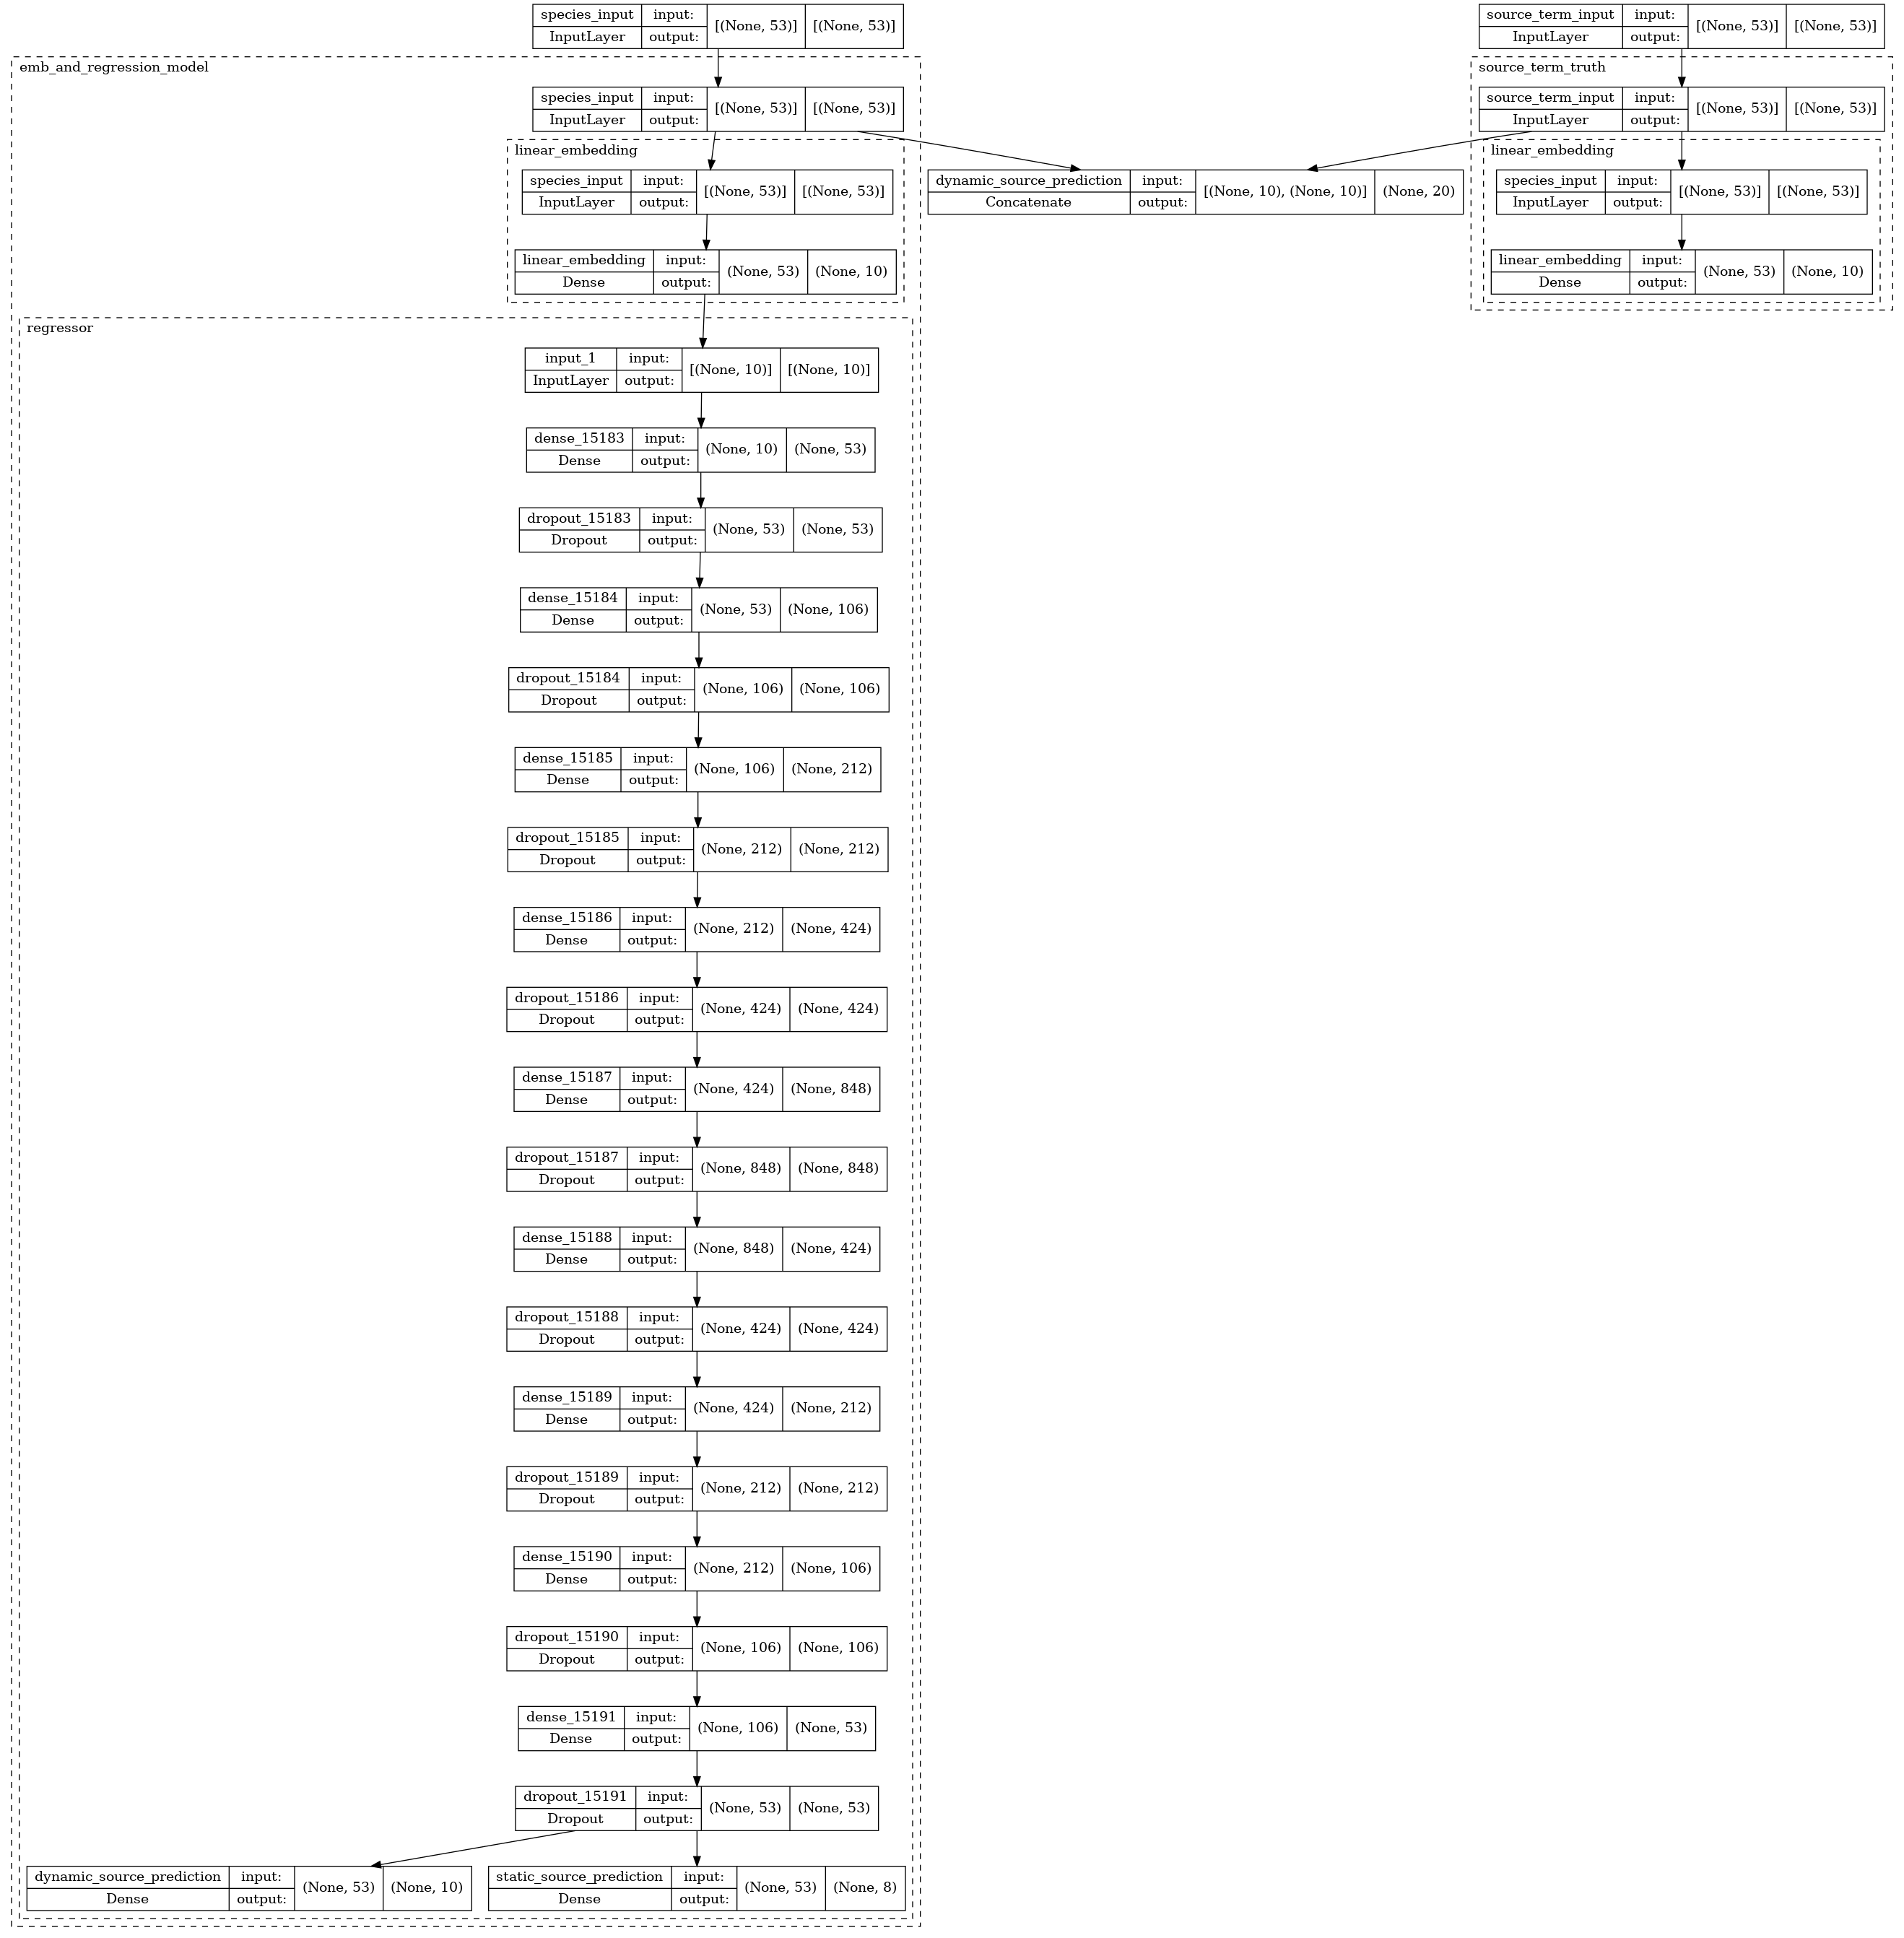

In [11]:
tf.keras.utils.plot_model(bestModel, expand_nested=True, show_shapes=True)

cpv8; 2.388228e+05 +/- 3.508030e+03
cpv6; 8.105315e+04 +/- 2.118779e+03
cpv4; 7.307592e+04 +/- 1.409834e+03
cpv5; 5.657408e+04 +/- 1.277560e+03
cpv3; 4.152435e+04 +/- 1.150087e+03
cpv2; 1.343554e+04 +/- 1.228968e+03
cpv10; 1.389417e+03 +/- 1.050717e+03
cpv9; -1.685831e+04 +/- 1.991926e+02
cpv1; -2.207209e+04 +/- 9.439816e+02
cpv7; -4.347558e+04 +/- 1.152373e+03


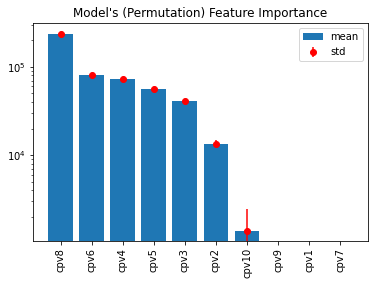

In [12]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

In [34]:
bestModel.get_layer('linear_embedding').summary()

Model: "linear_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 53)]              0         
                                                                 
 linear_embedding (Dense)    (None, 10)                530       
                                                                 
Total params: 530
Trainable params: 530
Non-trainable params: 0
_________________________________________________________________


         cpv1      cpv2      cpv3      cpv4      cpv5      cpv6      cpv7  \
min  0.073025  0.050667  0.071514  0.044549  0.001275  0.154000  0.032337   
25%  0.086485  0.078705  0.084940  0.112167  0.051313  0.160255  0.041538   
50%  0.095029  0.082299  0.097887  0.149961  0.078698  0.170082  0.063259   
75%  0.107307  0.093955  0.107449  0.168775  0.093295  0.182950  0.106179   
max  0.127618  0.116765  0.133777  0.178626  0.101132  0.229394  0.176496   

         cpv8      cpv9     cpv10  
min  0.036550  0.049718  0.073074  
25%  0.047969  0.066076  0.126062  
50%  0.072019  0.076277  0.131638  
75%  0.126536  0.083754  0.136306  
max  0.215470  0.088097  0.146803  


/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


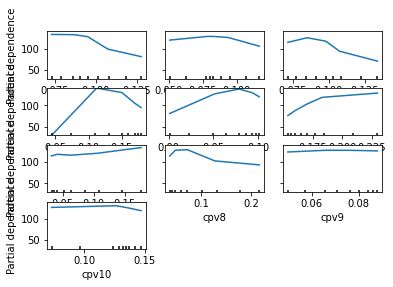

In [14]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

In [29]:
def getResiduals(Y_test,Y_pred):
    return Y_test-Y_pred

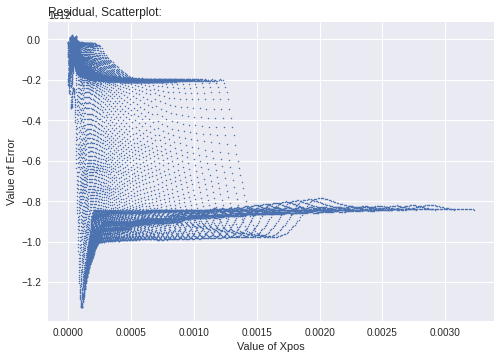

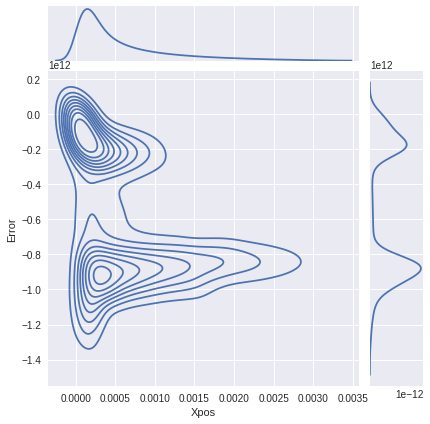

In [30]:
# TODO: Sanity check that this plots output ranges are correct? Seems like bug!
bestModel = exprExec.modelFactory.getEmbRegressor()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X,Y,rom,Zmix = dm.getAllData()
#X_train, X_test, Y_train, Y_test, rom_train, rom_test, zmix_train, zmix_test = dm.getTrainTestData()
Y_test = Y
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})['static_source_prediction']

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, dm.souener_index]
souener_test = opscaler.inverse_transform(Y_test)[:, dm.souener_index]

#residual/error

residuals = getResiduals(souener_test,souener_pred)

Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot( 'Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
#plt.title('Residual, Marginal Density plot:')

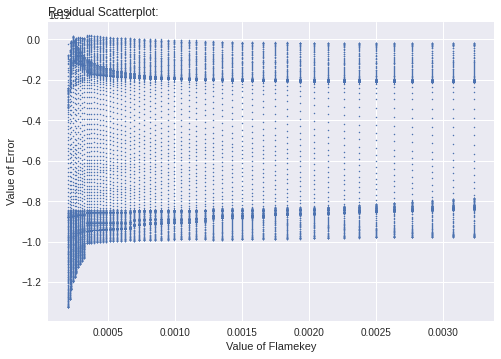

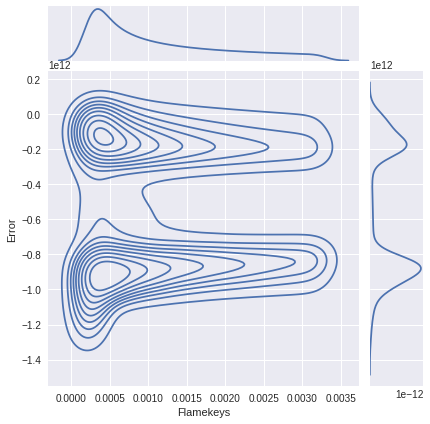

In [31]:
#residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = df['flame_key']#np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Y_test histogram')

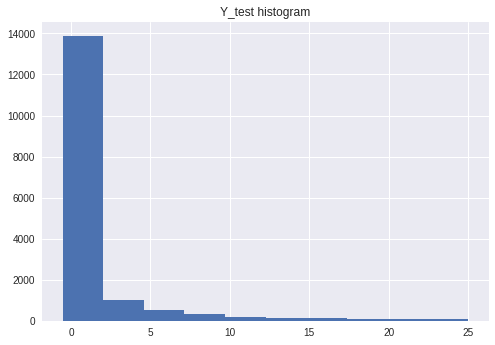

In [32]:
plt.hist(Y_test[:,0])
plt.title('Y_test histogram')

Text(0.5, 1.0, 'Y_pred histogram')

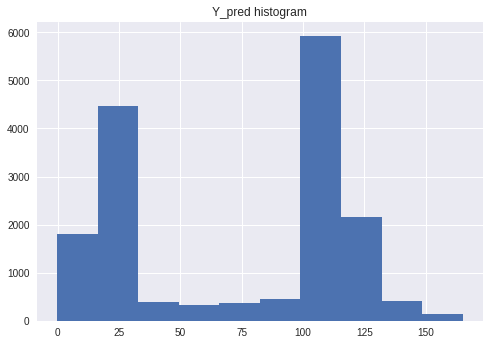

In [33]:
plt.hist(Y_pred[:,0])
plt.title('Y_pred histogram')